In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colors

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import itertools
import random
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle

In [2]:
load_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210427_anat_midline_flip/final2.nii"
corrs = np.array(nib.load(load_file).get_data(), copy=True)
corrs = np.swapaxes(corrs,2,3)
corrs.shape

(256, 128, 49, 3)

In [3]:
luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/luke_lowres.nii"
luke = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')
#luke = ants.from_numpy(luke)
#res_LUKE = (0.65, 0.65, 1)
#luke.set_spacing(res_LUKE)

In [23]:
luke.shape

(256, 128, 49)

In [4]:
corrs[np.where(corrs==0)] = np.nan

In [5]:
# Alpha Mask
avg_value = np.mean(np.nan_to_num(corrs),axis=-1)
mask = np.zeros(np.shape(avg_value))
mask[np.where(avg_value>0)] = 1
to_plot = np.concatenate((corrs, mask[:,:,:,np.newaxis]),axis=-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


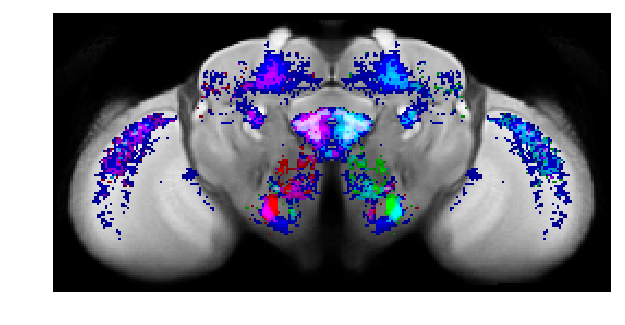

In [7]:
fig = plt.figure(figsize=(10,10))
plt.imshow(luke[:,:,25].T,cmap='gray')
plt.imshow(np.swapaxes(to_plot[:,:,25,:]*2,0,1))
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [58]:
luke[np.where(luke<.11)] = np.nan

(array([291814.,  80947.,  72584.,  65380.,  61861.,  65475.,  64142.,
         73637.,  75097.,  26565.]),
 array([7.09756689e-15, 9.87267792e-02, 1.97453558e-01, 2.96180338e-01,
        3.94907117e-01, 4.93633896e-01, 5.92360675e-01, 6.91087455e-01,
        7.89814234e-01, 8.88541013e-01, 9.87267792e-01]),
 <a list of 10 Patch objects>)

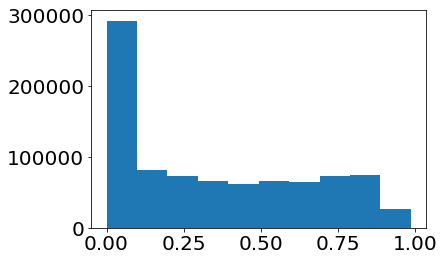

In [55]:
plt.hist(luke.flatten())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

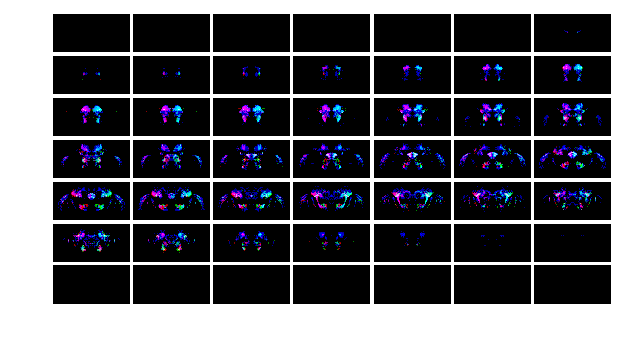

In [5]:
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(7, 7), axes_pad=.05)
for i in range(49):
    grid[i].imshow(np.swapaxes(corrs[:,:,i,:]*2,0,1));
    grid[i].axis('off')
    
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [8]:
file = F'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210130_superv_depth_correction/20210214_eigen_vectors_ztrim.npy'
vectors = np.load(file).real
print(f'vectors are {vectors.shape} voxel by PC')

vectors are (26840, 26840) voxel by PC


In [9]:
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210130_superv_depth_correction/labels.pickle'
with open(labels_file, 'rb') as handle:
    cluster_model_labels = pickle.load(handle)

In [10]:
running_sum = 0
new = []
for z in range(9,49-9):
    num_clusters = len(np.unique(cluster_model_labels[z]))
    new.append(vectors[running_sum:num_clusters+running_sum,:])
    running_sum += num_clusters

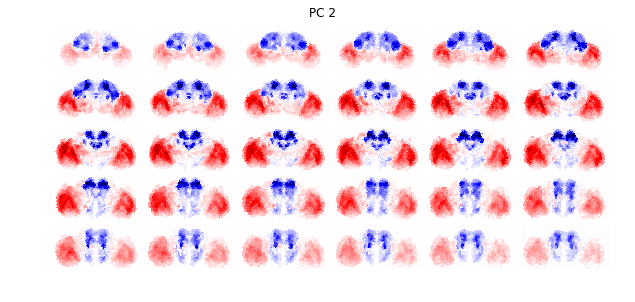

In [11]:
vmin = -.025
vmax = .025
pc = 1

fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 6), axes_pad=.05)
all_ = []
for i, z in enumerate(range(9,49-10)):
    colored_by_betas = np.zeros((256*128))
    for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
        cluster_indicies = np.where(cluster_model_labels[z][:]==cluster_num)[0]
        colored_by_betas[cluster_indicies] = new[z-9][cluster_num,pc]
    colored_by_betas = colored_by_betas.reshape(256,128)
    all_.append(colored_by_betas)
    cax = grid[i].imshow(colored_by_betas.T,vmin=vmin,vmax=vmax,cmap='seismic_r');

for i in range(30):
    grid[i].axis('off')

plt.suptitle(F'PC {pc+1}',y=.7,fontsize=12)
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [12]:
all_ = []
for z in range(9,49-9):
    colored_by_betas = np.zeros((256*128))
    for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
        cluster_indicies = np.where(cluster_model_labels[z][:]==cluster_num)[0]
        colored_by_betas[cluster_indicies] = new[z-9][cluster_num,pc]
    colored_by_betas = colored_by_betas.reshape(256,128)
    all_.append(colored_by_betas)
all_ = np.asarray(all_)
all_.shape

(31, 256, 128)

In [13]:
pad = np.zeros((9,256,128))
out = np.concatenate((pad,all_,pad))
out = np.moveaxis(out,0,2)
out.shape

(256, 128, 49)

In [14]:
### Load for warping to JRC space ###

fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/JRC2018_FEMALE_38um_iso_16bit.nii"
res_JRC2018 = (0.38, 0.38, 0.38)
fixed = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed = ants.from_numpy(fixed)
fixed.set_spacing(res_JRC2018)
fixed = ants.resample_image(fixed,(256,128,49),1,interp_type=1) #nearest neighbor
#fixed = ants.resample_image(fixed,res_LUKE,0,0)

affine_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/luke-to-jrc2018_fwdtransforms_lowres/tmps47el_wi0GenericAffine.mat"

In [15]:
res_LUKE = (2.6, 2.6, 5)
moving = ants.from_numpy(out[:,:,::-1])
moving.set_spacing(res_LUKE)

In [16]:
maps = ants.apply_transforms(fixed, moving, affine_file, interpolator='nearestNeighbor')

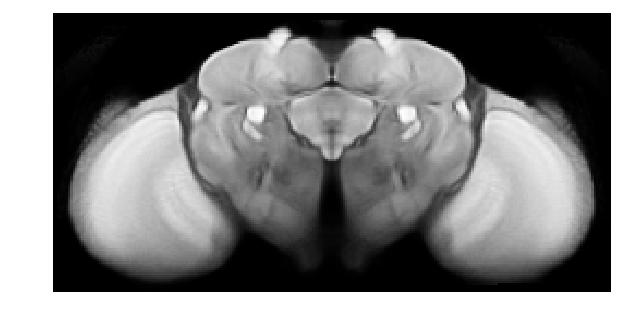

In [24]:
plt.figure(figsize=(10,10))
plt.imshow(luke[:,:,25].T,cmap='gray')
alphas = Normalize(.0001, .01, clip=True)(np.abs(maps[:,:,25]))
alphas = np.clip(alphas, 0, 1)  # alpha value clipped at the bottom
# Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
colors = Normalize(-.02, .02)(maps[:,:,25])
cmap = plt.cm.PuOr
colors = cmap(colors)
# Now set the alpha channel to the one we created above
colors[..., -1] = alphas
#plt.imshow(np.swapaxes(colors,0,1))
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [87]:
maps.shape

(256, 128, 49)

(-0.5, 255.5, 127.5, -0.5)

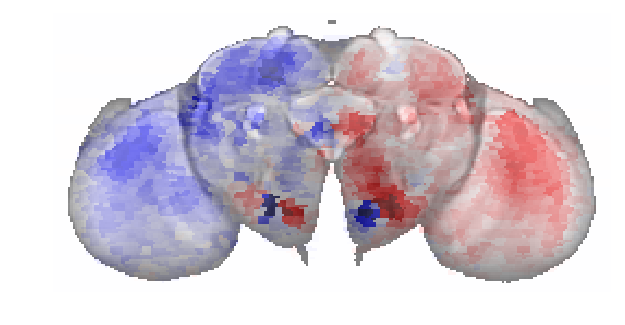

In [108]:
plt.figure(figsize=(10,10))
plt.imshow(luke[:,:,25].T,cmap='gray')
plt.imshow(maps[:,:,25].T,cmap='seismic_r',vmin=vmin,vmax=vmax,alpha=.5)
plt.axis('off')

(array([1.9000e+01, 2.0000e+01, 4.4000e+01, 5.5600e+02, 5.0990e+03,
        2.3841e+04, 2.8420e+03, 2.7000e+02, 5.2000e+01, 2.5000e+01]),
 array([-0.04475864, -0.03638567, -0.0280127 , -0.01963973, -0.01126676,
        -0.0028938 ,  0.00547917,  0.01385214,  0.02222511,  0.03059808,
         0.03897105]),
 <a list of 10 Patch objects>)

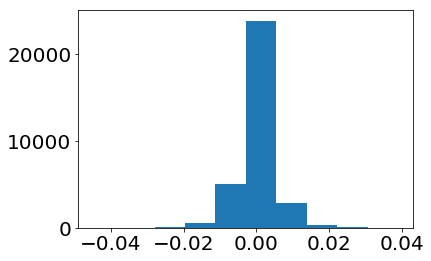

In [109]:
plt.hist(maps[:,:,25].flatten())